## Imports

In [1]:
import findspark
findspark.init()

from pyspark import *
from pyspark.sql.functions import desc, col
from pyspark.sql import *
from graphframes import *

import os
from IPython.display import display, HTML
from src.graph_algorithms import JaccardSimilarity, LabelPropagationAlgorithm
from src.data_utils import read_data, read_meta
from src.viz_utils import plot_graph, plot_n_nodes_vs_degree

Need to pass graphframes package to Spark, not pip.

In [2]:
# https://graphframes.github.io/graphframes/docs/_site/quick-start.html
# https://stackoverflow.com/questions/65011599/how-to-start-graphframes-on-spark-on-pyspark-on-juypter-on-docker
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'

## Setup, Download and Read Data

Start Spark context.

In [3]:
spark = SparkSession.builder.appName('graph_test').config('spark.executor.memory','8g').config('spark.driver.memory','8g').config('spark.driver.maxResultsSize','0').getOrCreate()

Download data.

Product co-purchasing networks by Amazon, available at http://snap.stanford.edu/data/#amazon

The datafiles contain Directed edges in the amazon0302 file, and a meta-data file called amazon-meta.

Read data, and build Pandas DataFrames for vertices, edges, and meta-data.

In [4]:
df_edges, df_vertices_no_meta = read_data(from_file_name="../../data/amazon0302.txt")
df_meta = read_meta(from_file_name="../../data/amazon-meta.txt")

display(HTML(df_edges.head(10).to_html()))
display(HTML(df_vertices_no_meta.head(10).to_html()))
display(HTML(df_meta.head(10).to_html()))

100%|█████████▉| 15010569/15010572 [00:08<00:00, 1714646.09it/s]


,src,dst
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,1,0
6,1,2
7,1,4
8,1,5
9,1,15


,id
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


,id,title,group,salesrank,reviews
0,1,Patterns of Preaching: A Sermon Sampler,book,396585,5.0
1,2,Candlemas: Feast of Flames,book,168596,4.5
2,3,World War II Allied Fighter Planes Trading Cards,book,1270652,5.0
3,4,Life Application Bible Commentary: 1 and 2 Timothy and Titus,book,631289,4.0
4,5,Prayers That Avail Much for Business: Executive,book,455160,0.0
5,6,How the Other Half Lives: Studies Among the Tenements of New York,book,188784,4.0
6,7,Batik,music,5392,4.5
7,8,Losing Matt Shepard,book,277409,4.5
8,9,Making Bread: The Taste of Traditional Home-Baking,book,949166,0.0
9,10,The Edward Said Reader,book,220379,4.0


## Building the Graph: From Pandas to GraphFrames

Convert Pandas DataFrames to Spark DataFrames.

In [5]:
# could take 1 min
vertices_no_meta = spark.createDataFrame(df_vertices_no_meta, list(df_vertices_no_meta.columns.values))
edges = spark.createDataFrame(df_edges, list(df_edges.columns.values))
meta = spark.createDataFrame(df_meta, list(df_meta.columns.values))

Inner join no-meta vertices table with meta-data table on id.

In [6]:
vertices = \
    vertices_no_meta.\
    join(meta, vertices_no_meta["id"] == meta["id"], "inner").\
    drop(meta.id)

vertices.show()

+----+--------------------+-----+---------+-------+
|  id|               title|group|salesrank|reviews|
+----+--------------------+-----+---------+-------+
|  26|      Chicken Little| book|   242571|    4.0|
|  29|Advanced Pediatri...| book|   677416|    0.0|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
| 964|Outsmarting the S...| book|   536872|    4.5|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|1697|Experiences in Mo...| book|   695386|    0.0|
|1806|Black Stallion an...| book|    71706|    5.0|
|1950|Applied Blood Gro...| book|   985020|    5.0|
|2040|The Minority Repo...| book|   326911|    4.5|
|2214|The Arts of the S...| book|   923205|    4.0|
|2250|         Yummy Yummy|music|   170306|    4.5|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|2509|Girls, Delinquenc...| book|   559169|    5.0|
|2529|When You look Lik...| book|   667405|    5.0|
|2927|The Art of Outdoo...| book|   299959|    4.5|
|3091|Blue Moon Cat: Li...|music|   379772|    2.0|
|3506|Fire o

Build GraphFrames graph from vertices and edges.

In [7]:
g = GraphFrame(vertices, edges)

g.vertices.show()
g.edges.show()

print(f"g.vertices.shape = {g.vertices.count(), len(g.vertices.columns)}")
print(f"g.edges.shape = {g.edges.count(), len(g.edges.columns)}")

+----+--------------------+-----+---------+-------+
|  id|               title|group|salesrank|reviews|
+----+--------------------+-----+---------+-------+
|  26|      Chicken Little| book|   242571|    4.0|
|  29|Advanced Pediatri...| book|   677416|    0.0|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
| 964|Outsmarting the S...| book|   536872|    4.5|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|1697|Experiences in Mo...| book|   695386|    0.0|
|1806|Black Stallion an...| book|    71706|    5.0|
|1950|Applied Blood Gro...| book|   985020|    5.0|
|2040|The Minority Repo...| book|   326911|    4.5|
|2214|The Arts of the S...| book|   923205|    4.0|
|2250|         Yummy Yummy|music|   170306|    4.5|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|2509|Girls, Delinquenc...| book|   559169|    5.0|
|2529|When You look Lik...| book|   667405|    5.0|
|2927|The Art of Outdoo...| book|   299959|    4.5|
|3091|Blue Moon Cat: Li...|music|   379772|    2.0|
|3506|Fire o

## ## Qualitative Graph Analysis: Graph Visualization and Degree Plots

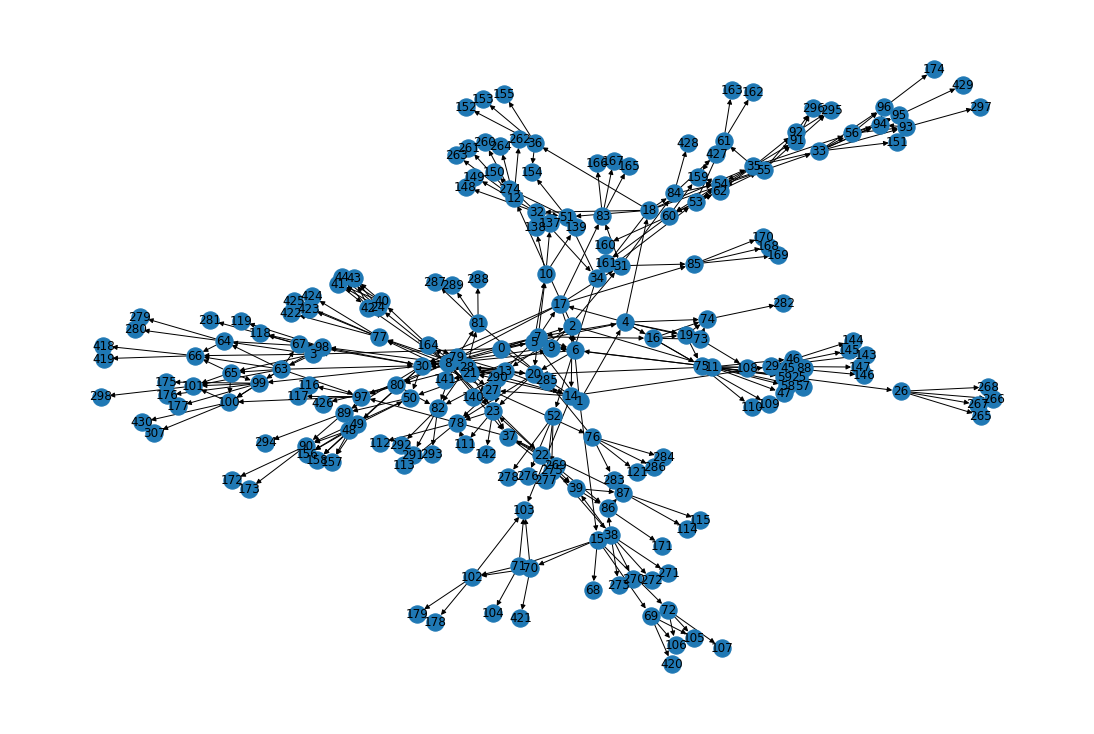

In [20]:
take_n = 500
path_fig = f"assets/graph_viz_n_{take_n}.png"
plot_graph(g.edges, path_fig=path_fig, take_n=take_n)

The ratio between the in and out degrees is the degree ratio. A higher ratio value will tell us where many purchases end (but rarely begin), while a lower value tells us where purchases often begin (but infrequently end).

In [9]:
degree_ratio_df = g.inDegrees.join(g.outDegrees, "id", "outer").selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio")
degree_ratio_df.orderBy(desc("degreeRatio")).show(10)

+-----+-----------+
|   id|degreeRatio|
+-----+-----------+
|14949|       84.0|
| 4429|       80.8|
|   33|       72.2|
|10519|       66.8|
|12771|       66.0|
|    8|       58.6|
|  481|       55.0|
| 3910|       55.0|
| 5737|       54.4|
| 9106|       45.4|
+-----+-----------+
only showing top 10 rows



In [10]:
degrees_df = \
    g.degrees.\
    join(g.inDegrees, "id", "outer").\
    join(g.outDegrees, "id", "outer").\
    join(degree_ratio_df, "id", "outer").\
    drop(g.outDegrees.id).\
    drop(g.inDegrees.id).\
    drop(degree_ratio_df.id).\
    na.fill(0).\
    sort(desc("degree"))

degrees_df.show()
degrees_df.toPandas().to_csv("assets/degrees_df.csv")

+-----+------+--------+---------+-----------+
|   id|degree|inDegree|outDegree|degreeRatio|
+-----+------+--------+---------+-----------+
|14949|   425|     420|        5|       84.0|
| 4429|   409|     404|        5|       80.8|
|   33|   366|     361|        5|       72.2|
|10519|   339|     334|        5|       66.8|
|12771|   335|     330|        5|       66.0|
|    8|   298|     293|        5|       58.6|
|  481|   280|     275|        5|       55.0|
|  297|   280|     280|        0|        0.0|
| 5737|   277|     272|        5|       54.4|
| 9106|   232|     227|        5|       45.4|
| 8939|   226|     221|        5|       44.2|
|   93|   224|     219|        5|       43.8|
| 1241|   223|     218|        5|       43.6|
| 5765|   214|     209|        5|       41.8|
| 2501|   196|     191|        5|       38.2|
|   99|   193|     188|        5|       37.6|
| 3661|   186|     181|        5|       36.2|
|  244|   184|     179|        5|       35.8|
| 2353|   184|     179|        5| 

In [11]:
# Convert degree GraphFrames to lists for plotting.
degrees_list = [int(d.degree) for d in degrees_df.select('degree').collect()]
in_degree_list = [int(d.inDegree) for d in degrees_df.select('inDegree').collect()]
out_degree_list = [int(d.outDegree) for d in degrees_df.select('outDegree').collect()]

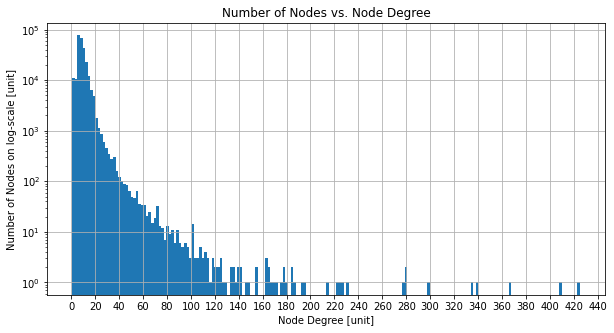

In [12]:
x = degrees_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Degree [unit]"
title = "Number of Nodes vs. Node Degree"
save_path = "assets/n_nodes_vs_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

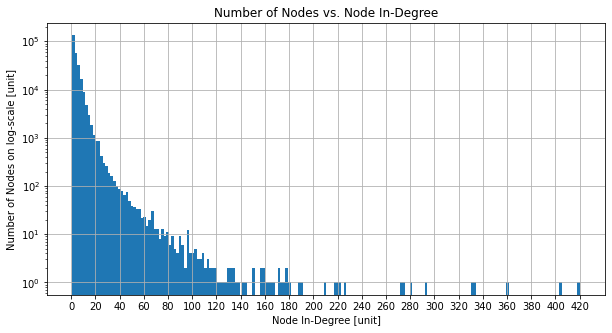

In [13]:
x = in_degree_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node In-Degree [unit]"
title = "Number of Nodes vs. Node In-Degree"
save_path = "assets/n_nodes_vs_in_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

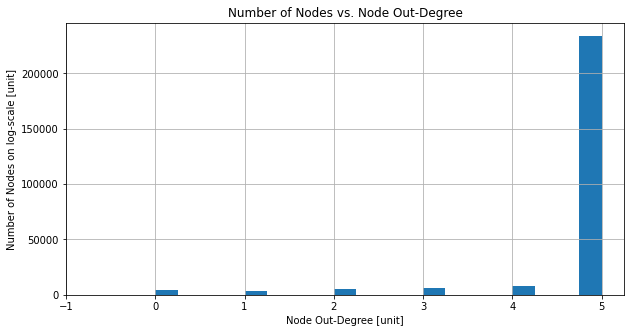

In [14]:
x = out_degree_list
n_bins = 20
x_step = 1
yscale = "linear"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Out-Degree [unit]"
title = "Number of Nodes vs. Node Out-Degree"
save_path = "assets/n_nodes_vs_out_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

## Quantitative Graph Analysis: Motifs, Triangles, PageRank, Label Propagation, and Jaccard Similarity

### Motif Finding

Use  GraphFrames motifs (sort of reg-ex on graphs) to find mutually co-purchased products, i.e.:  a<->mutual<->c node structure

In [17]:
# b is mutually copurchased with a and c
mutually_copurchased_products_df = g.find("(a)-[]->(mutual); (mutual)-[]->(c); (c)-[]->(mutual); (mutual)-[]->(a)").dropDuplicates()
print(mutually_copurchased_products_df.count())
mutually_copurchased_products_df.show()

2200504
+---------------------+--------------------+---------------------+
|                    a|              mutual|                    c|
+---------------------+--------------------+---------------------+
|{125, Adobe庐 InDe...|{136, Understandi...|{125, Adobe庐 InDe...|
| {380, Systematic ...|{659, Lean Back, ...| {1163, Jarreau, m...|
| {2602, California...|{867, Rope Around...| {281, Tropic of C...|
| {2743, Young Math...|{1238, Custer, Bl...| {2744, Past Life ...|
| {5328, In the Beg...|{1945, Abba's Chi...| {5328, In the Beg...|
| {3656, Trouble wi...|{2777, Starting W...| {2773, The Diabet...|
| {3589, I Was Aboa...|{4930, Horses Nev...| {9809, Speaking i...|
| {8382, Black Sept...|{6647, The Scopes...| {8382, Black Sept...|
| {4797, Baby-Sitte...|{6680, No Marriag...| {4797, Baby-Sitte...|
| {8401, Just the T...|{6845, Buy and Ho...| {8401, Just the T...|
| {5087, Out of the...|{7321, Lost Weeke...| {5087, Out of the...|
| {24836, The Contr...|{8186, Too Much o...| {18433, In 

### Traingle Count

Traingle counts for finding important products.

In [18]:
triangle_count_df = g.triangleCount().sort(desc("count"))
triangle_count_df.show()

triangle_count_df.toPandas().to_csv("assets/traingle_count_df.csv")

+-----+-----+--------------------+-----+---------+-------+
|count|   id|               title|group|salesrank|reviews|
+-----+-----+--------------------+-----+---------+-------+
|  509|14949|Fodor's Australia...| book|   793062|    5.0|
|  442| 4429|Harley-Davidson P...| book|   147799|    4.5|
|  427|10519|             Pilgrim|music|   141107|    4.5|
|  419|  481|A Major Case: A N...| book|  2860756|    4.5|
|  396|  244|    Phonics Pathways| book|   136845|    4.5|
|  334| 8939|Gene Chandler - 2...|music|    58208|    4.5|
|  278| 7153|Handbook of Psych...| book|   195552|    5.0|
|  274| 1241|  Accessible Physics| book|  2924393|    0.0|
|  269|82909|Aerosmith/Get You...|music|   117949|    5.0|
|  255|80341|Gagana Samoa: A S...| book|   267807|    3.0|
|  252| 1825|Instant Wireless ...| book|   853770|    4.5|
|  240| 5913|A Race Is a Nice ...| book|    78144|    4.5|
|  237|  241|Unsettling Americ...| book|   301257|    5.0|
|  234|   33|Double Jeopardy (...| book|    97166|    5.

### PageRank

Pagreank algorithm to find the most important prroduct.

In [21]:
pagerank = g.pageRank(resetProbability=0.15, maxIter=5) #maxIter=5

In [22]:
pagerank_df = pagerank.vertices.orderBy("pagerank", ascending=False)
pagerank_df.show()

pagerank_df.toPandas().to_csv("assets/pagerank_df.csv")

+----+---------------------+-----+---------+-------+------------------+
|  id|                title|group|salesrank|reviews|          pagerank|
+----+---------------------+-----+---------+-------+------------------+
|  33| Double Jeopardy (...| book|    97166|    5.0|  256.865019479512|
|  93|BizPricer驴 Busine...| book|  1485593|    0.0|222.28038731548077|
|4429| Harley-Davidson P...| book|   147799|    4.5| 186.2275745547629|
|   8|  Losing Matt Shepard| book|   277409|    4.5| 184.5995037805267|
|2501| The Narcissistic ...| book|     9727|    5.0|176.16085273457895|
|  94| The American Heri...| book|   166549|    4.0| 163.6754451816444|
| 151| Laurel & Hardy - ...|  dvd|    44671|    3.0|163.31819625369934|
|  56| Three Bricks Shy ...| book|  2167012|    0.0|145.49653670139423|
|  95| The Heavy Flak Gu...| book|  1369585|    0.0|144.27429036648192|
|2353|            Committed|music|   437762|    5.0|141.02818514868358|
|9106| A Touch Of Tranqu...|music|    39971|    5.0|120.113371142

### Label Propagation Algorithm (LPA) for Recommendation

In [23]:
max_iter = 5 #max_iter = 5
lpa = LabelPropagationAlgorithm(g=g, max_iter=max_iter)

LPA has been fit to graph


In [25]:
community_df = lpa.get_communities()
community_df.show()
community_df.toPandas().to_csv("assets/community_df.csv")

n_labels = lpa.get_communities().select("label").distinct().count()
print(f"LPA found {n_labels} labels after {max_iter} iteration(s)")

community_counts_df = lpa.get_communities().groupBy(col("label")).count().orderBy(desc("count"))
community_counts_df.show()

community_counts_df.toPandas().to_csv("assets/community_counts_df.csv")

+----+--------------------+-----+---------+-------+------+
|  id|               title|group|salesrank|reviews| label|
+----+--------------------+-----+---------+-------+------+
|  26|      Chicken Little| book|   242571|    4.0|   382|
|  29|Advanced Pediatri...| book|   677416|    0.0|   146|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|  8158|
| 964|Outsmarting the S...| book|   536872|    4.5| 60577|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|  6465|
|1697|Experiences in Mo...| book|   695386|    0.0|   831|
|1806|Black Stallion an...| book|    71706|    5.0|  1806|
|1950|Applied Blood Gro...| book|   985020|    5.0|  1207|
|2040|The Minority Repo...| book|   326911|    4.5|  2039|
|2214|The Arts of the S...| book|   923205|    4.0|  2111|
|2250|         Yummy Yummy|music|   170306|    4.5|138055|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|  1483|
|2509|Girls, Delinquenc...| book|   559169|    5.0|  1824|
|2529|When You look Lik...| book|   667405|    5.0|  151

Use LPA to get a recommendation for a product.

In [26]:
id_ = 10
recommend_n = 5
g.vertices.filter(f"id = {id_}").show()
g.vertices.filter(f"id = {id_}").toPandas().to_csv(f"assets/df_nodeid_{id_}.csv")

recommendations_df = lpa(id_= id_)
recommendations_df.show(recommend_n)
recommendations_df.limit(recommend_n).toPandas().to_csv(f"assets/recommendations_df_lpa_nodeid_{id_}.csv")

+---+--------------------+-----+---------+-------+
| id|               title|group|salesrank|reviews|
+---+--------------------+-----+---------+-------+
| 10|The Edward Said R...| book|   220379|    4.0|
+---+--------------------+-----+---------+-------+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|11699|Getting to the Be...| book|   552678|    5.0|11701|
| 5554|       The Decameron| book|   441660|    5.0|11701|
|11700|Middlemarch (Word...| book|  1216188|    4.5|11701|
|11698|Food Folklore : T...| book|   779866|    0.0|11701|
|13805|Great Overtures i...| book|   801312|    0.0|11701|
+-----+--------------------+-----+---------+-------+-----+



In [27]:
id_ = 20
recommend_n = 5
g.vertices.filter(f"id = {id_}").show()
g.vertices.filter(f"id = {id_}").toPandas().to_csv(f"assets/df_nodeid_{id_}.csv")

recommendations_df = lpa(id_= id_)
recommendations_df.show(recommend_n)

recommendations_df.limit(recommend_n).toPandas().to_csv(f"assets/recommendations_df_lpa_nodeid_{id_}.csv")

+---+--------------------+-----+---------+-------+
| id|               title|group|salesrank|reviews|
+---+--------------------+-----+---------+-------+
| 20|Computed Tomograp...| book|   179448|    5.0|
+---+--------------------+-----+---------+-------+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
| 5415|Lucky Luke, Vol. ...|  dvd|    28420|    5.0|   23|
|   80|In Quest of God: ...| book|   533031|    5.0|   23|
|  455|Midwinter Night's...|music|    59751|    5.0|   23|
|25867|    Hang On, Hopper!| book|  1116593|    5.0|   23|
| 2600|Street Foods: Urb...| book|  1402441|    5.0|   23|
+-----+--------------------+-----+---------+-------+-----+
only showing top 5 rows



In [28]:
id_ = 12345
recommend_n = 5
g.vertices.filter(f"id = {id_}").show()
g.vertices.filter(f"id = {id_}").toPandas().to_csv(f"assets/df_nodeid_{id_}.csv")

recommendations_df = lpa(id_= id_)
recommendations_df.show(recommend_n)

recommendations_df.limit(recommend_n).toPandas().to_csv(f"assets/recommendations_df_lpa_nodeid_{id_}.csv")

+-----+-----+-----+---------+-------+
|   id|title|group|salesrank|reviews|
+-----+-----+-----+---------+-------+
|12345| Maya|music|    64984|    5.0|
+-----+-----+-----+---------+-------+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|10508|The V Zone : A Wo...| book|   352991|    5.0|10508|
| 5381|Noah'S Ark (Littl...| book|   399319|    5.0|10508|
|10509|Tchaikovsky: Pian...|music|    76777|    4.5|10508|
|17238|      Q's Jook Joint|music|     5440|    4.5|10508|
|10510|Tristana (Easy Re...| book|   991608|    4.0|10508|
+-----+--------------------+-----+---------+-------+-----+
only showing top 5 rows



### Jaccard Similarity for Recommendation

In [29]:
id_ = 10
recommend_n = 5
jsp = JaccardSimilarity(g=g, id_=id_, spark=spark)

g.vertices.filter(f"id = {id_}").show()
g.vertices.filter(f"id = {id_}").toPandas().to_csv(f"assets/df_nodeid_{id_}.csv")

vertices_similar_df = jsp()
vertices_similar_df.show(recommend_n)
vertices_similar_df.limit(recommend_n).toPandas().to_csv(f"assets/recommendations_df_js_nodeid_{id_}.csv")

+---+--------------------+-----+---------+-------+
| id|               title|group|salesrank|reviews|
+---+--------------------+-----+---------+-------+
| 10|The Edward Said R...| book|   220379|    4.0|
+---+--------------------+-----+---------+-------+

+---+--------------------+-----+---------+-------+-------------------+
| id|               title|group|salesrank|reviews|            jaccard|
+---+--------------------+-----+---------+-------+-------------------+
|137|Apples of Gold: A...| book|   129355|    5.0|0.42857142857142855|
|139|  The Sacred Impulse| book|   846457|    3.0|0.42857142857142855|
|  7|               Batik|music|     5392|    4.5| 0.1111111111111111|
|  5|Prayers That Avai...| book|   455160|    0.0| 0.1111111111111111|
|138|The McClurkin Pro...|music|    54277|    4.0|                0.0|
+---+--------------------+-----+---------+-------+-------------------+



In [ ]:
id_ = 20
recommend_n = 5
jsp = JaccardSimilarity(g=g, id_=id_, spark=spark)

g.vertices.filter(f"id = {id_}").show()
g.vertices.filter(f"id = {id_}").toPandas().to_csv(f"assets/df_nodeid_{id_}.csv")

vertices_similar_df = jsp()
vertices_similar_df.show(recommend_n)
vertices_similar_df.limit(recommend_n).toPandas().to_csv(f"assets/recommendations_df_js_nodeid_{id_}.csv")

21/10/21 23:40:18 WARN TaskSetManager: Stage 888 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:19 WARN TaskSetManager: Stage 887 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:19 WARN TaskSetManager: Stage 892 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:21 WARN TaskSetManager: Stage 895 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:22 WARN TaskSetManager: Stage 898 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:23 WARN TaskSetManager: Stage 900 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:25 WARN TaskSetManager: Stage 906 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.

+---+--------------------+-----+---------+-------+
| id|               title|group|salesrank|reviews|
+---+--------------------+-----+---------+-------+
| 20|Computed Tomograp...| book|   179448|    5.0|
+---+--------------------+-----+---------+-------+



21/10/21 23:40:39 WARN TaskSetManager: Stage 956 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:39 WARN TaskSetManager: Stage 958 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:41 WARN TaskSetManager: Stage 962 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+---+--------------------+-----+---------+-------+------------------+
| id|               title|group|salesrank|reviews|           jaccard|
+---+--------------------+-----+---------+-------+------------------+
|  7|               Batik|music|     5392|    4.5|              0.25|
|  6|How the Other Hal...| book|   188784|    4.0|              0.25|
|  8| Losing Matt Shepard| book|   277409|    4.5|0.1111111111111111|
| 23|Strange Fire: A N...| book|  1277867|    3.0|0.1111111111111111|
| 30|Solving Statics P...| book|   227883|    0.0|0.1111111111111111|
+---+--------------------+-----+---------+-------+------------------+



In [ ]:
id_ = 12345
recommend_n = 5
jsp = JaccardSimilarity(g=g, id_=id_, spark=spark)

g.vertices.filter(f"id = {id_}").show()
g.vertices.filter(f"id = {id_}").toPandas().to_csv(f"assets/df_nodeid_{id_}.csv")

vertices_similar_df = jsp()
vertices_similar_df.show(recommend_n)
vertices_similar_df.limit(recommend_n).toPandas().to_csv(f"assets/recommendations_df_js_nodeid_{id_}.csv")

21/10/21 23:40:42 WARN TaskSetManager: Stage 967 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:43 WARN TaskSetManager: Stage 969 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:44 WARN TaskSetManager: Stage 971 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:46 WARN TaskSetManager: Stage 976 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:47 WARN TaskSetManager: Stage 978 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:48 WARN TaskSetManager: Stage 980 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:40:49 WARN TaskSetManager: Stage 985 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.

+-----+-----+-----+---------+-------+
|   id|title|group|salesrank|reviews|
+-----+-----+-----+---------+-------+
|12345| Maya|music|    64984|    5.0|
+-----+-----+-----+---------+-------+



21/10/21 23:40:59 WARN TaskSetManager: Stage 1027 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 23:41:00 WARN TaskSetManager: Stage 1031 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+-----+---------+-------+------------------+
|   id|               title|group|salesrank|reviews|           jaccard|
+-----+--------------------+-----+---------+-------+------------------+
|17238|      Q's Jook Joint|music|     5440|    4.5|0.2857142857142857|
|13137|Beggar's Ride (Be...| book|   322234|    3.0|0.2857142857142857|
|12344|The Use and Abuse...| book|   581060|    0.0|0.2857142857142857|
|10510|Tristana (Easy Re...| book|   991608|    4.0|             0.125|
+-----+--------------------+-----+---------+-------+------------------+



21/10/21 23:41:02 WARN TaskSetManager: Stage 1034 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
